# GMM Gym

Minimal working example of a GMM!

## 1. Setup

+ 1.1 Set up real deep parameters ($\lambda_0 = f(X, \theta)$)
+ 1.2 Get ValueF and optimal policy function
+ 1.3 Simulate demand and optimal pricing for N firms

## 2. Estimating $\theta$

Try $\theta$ until error < $\varepsilon$

+ 2.1. $\theta$ values generate a $\lambda_0$
+ 2.2. $\lambda_0$ + demand observations + optimal pricing generate pricing decisions
+ 2.3. $error = \left|pricing decisions - observed pricing\right|$


## 1. Setup

In [4]:
import numpy as np
from typing import Callable
%matplotlib inline
import matplotlib.pyplot as plt
import dill
import numpy as np
import pandas as pd
    
import sys
sys.path.append('../')
import src

# Simulation parameters \
########################
σerror= 0.005 #0.01
Nfirms = 300
time_periods = 40

#Suitable for logistic
β10, β11 = -2., 3.
β20, β21 = 0.03, -2.
betas = [β10, β11, β20, β21]


def lambda_0(x, prior_shock) -> np.ndarray:
    """
    Generate a vector of lambdas on the observables x
    """
    return src.from_theta_to_lambda0(x, θ=betas, prior_shock=prior_shock)


def get_lambdas_from_x(xs, prior_shocks):
    y = np.empty((len(xs), 3), dtype=float)
    for i in range(len(xs)):
        y[i] = lambda_0(xs[i], prior_shocks[i])
    return y

xs = np.abs(np.random.normal(0, 0.18, size=Nfirms))
prior_shocks = src.gen_prior_shocks(Nfirms)
lambdas0 = get_lambdas_from_x(xs, prior_shocks)
lambdas0[0:10]



array([[0.35304688, 0.2941467 , 0.58729796],
       [0.12978533, 0.49461854, 0.59281051],
       [0.20758934, 0.40096166, 0.59663147],
       [0.12757316, 0.494275  , 0.59342727],
       [0.19590857, 0.4114474 , 0.59691903],
       [0.20425161, 0.40108974, 0.59740367],
       [0.19837608, 0.41181795, 0.59623599],
       [0.11911325, 0.50588645, 0.59266667],
       [0.16262345, 0.44689478, 0.59639867],
       [0.14972863, 0.46675128, 0.59472183]])

In [5]:
file_n = "2018-10-5vfi_dict.dill"
with open('../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)


dmd_shocks = src.generate_dmd_shocks(n=Nfirms, t=time_periods, dmd_σϵ=src.const.σ_ɛ)

df = src.simulate_all_firms(Nfirms, valueF, policyF, xs, θ=betas,
                   dmd_shocks=dmd_shocks, prior_shocks=prior_shocks)

## Estimating $\theta$

+ 2.1. $\theta$ values generate a $\lambda_0$

(defined aboved)

+ 2.2. $\lambda_0$ + demand observations + optimal pricing generate pricing decisions

In [7]:
src.generate_pricing_decisions(policyF, np.array([0.2, 0.6, 0.2]),
                               df[df.firm == 15].log_dmd.values)[0:4]




array([2.32068966, 2.05135741, 2.24369715, 2.61872996])

+ 2.3. $error = \left|pricing decisions - observed pricing\right|$

+ Do I choose moments?

In [6]:
test_df = pd.DataFrame({'level_prices': [2., 3., 4., 1., 2.1, 2.1, 2.1, 2.5],
                       'firm': [0, 0, 0, 0, 0, 1, 1, 1],
                       't': [0, 1, 2, 3, 4, 0, 1, 2]})

test_df.groupby('firm')[['level_prices', 't']].rolling(window=3).std()



level_prices    t
firm                     
0    0           NaN  NaN
     1           NaN  NaN
     2      1.000000  1.0
     3      1.527525  1.0
     4      1.517674  1.0
1    5           NaN  NaN
     6           NaN  NaN
     7      0.230940  1.0

In [8]:
#Generate running std (to start)
std_devs = (df.groupby('firm').level_prices.rolling(window=4, min=3)
            .std().reset_index()
            .rename(columns={'level_1': 't',
                            'level_prices': 'std_dev_prices'}))

df = pd.merge(df, std_devs, on=['firm', 't'], how='left')



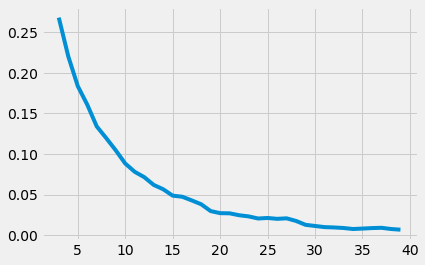

In [9]:

rolling_std_price = src.generate_mean_std_pricing_decisions(df, policyF, 
                                                            lambdas_at_0=lambdas0)
plt.style.use('fivethirtyeight')
plt.plot(rolling_std_price)


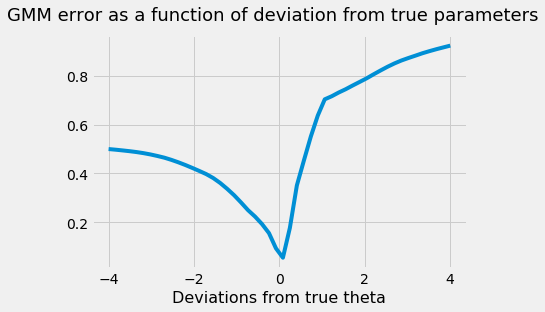

In [10]:
min_periods = 3

mean_std_observed_prices = df.groupby('t').std_dev_prices.mean()[min_periods:]

real_theta = np.array([-2, 3, 0.03, -2])

error = []
deviation = np.linspace(-4, 4, 50)
thetas = real_theta + deviation[:, np.newaxis]

for theta in thetas:
    error.append(src.std_moments_error(theta, policyF, xs, mean_std_observed_prices,
                                       prior_shocks, df, min_periods=3))

fig, ax = plt.subplots(1, 1)
ax.plot(deviation, error)
ax.set_xlabel("Deviations from true theta", size=16)
fig.suptitle("GMM error as a function of deviation from true parameters", size=18);



## 3. Optimize

## Optimize with moments

In [11]:
min_periods = 3

mean_std_observed_prices = df.groupby('t').std_dev_prices.mean()[min_periods:]

def error_w_data(θ):
    return std_moments_error(θ, policyF, xs,
                      mean_std_observed_prices=mean_std_observed_prices,
                             min_periods=3)



In [28]:
trueθ0 = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+0.3, β11-0.05, β20+0.1, β21-0.05])
trueθ0



array([-2.  ,  3.  ,  0.03, -2.  ])

In [29]:
badθ0

array([-1.7 ,  2.95,  0.13, -2.05])

In [32]:
from scipy import optimize as opt
true_params = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+2, β11-1, β20+1, β21-3])

opt.minimize(error_w_data, badθ0,
             method='Nelder-Mead', options={'maxiter': 100, 'disp': True})



 final_simplex: (array([[ 5.29954226e-03, -1.02871296e+01,  2.48956659e+00,
        -1.67859115e+01],
       [ 5.29953737e-03, -1.02871300e+01,  2.48956580e+00,
        -1.67859118e+01],
       [ 5.29953842e-03, -1.02871296e+01,  2.48956610e+00,
        -1.67859126e+01],
       [ 5.29954718e-03, -1.02871302e+01,  2.48956817e+00,
        -1.67859116e+01],
       [ 5.29955079e-03, -1.02871298e+01,  2.48956906e+00,
        -1.67859073e+01]]), array([0.54721217, 0.5472142 , 0.54722698, 0.54749134, 0.54752757]))
           fun: 0.547212174134108
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 213
           nit: 100
        status: 2
       success: False
             x: array([ 5.29954226e-03, -1.02871296e+01,  2.48956659e+00, -1.67859115e+01])

In [40]:
import time
start = time.time()
maxiters=20
optimi = opt.differential_evolution(error_w_data, [(-2.5, 0.5), (3., 3.2),
                                                   (-0.5, 0.2), (-3, 1)],
                          maxiter=maxiters)

time_taken =  time.time()/60 - start/60 
print("Taken {0} minutes for {1} iterations. {2} per iteration".format(
      time_taken, maxiters, time_taken/maxiters))


Taken 25.056923247873783 minutes for 20 iterations. 1.252846162393689 per iteration


In [42]:
optimi

     fun: 0.05481654620070882
     jac: array([ 3.18902989, -0.10044244, 68.01941874, -0.46822872])
 message: 'Optimization terminated successfully.'
    nfev: 1420
     nit: 18
 success: True
       x: array([-1.86544625e+00,  3.14486084e+00, -1.03523282e-01,  2.11626146e-03])

In [39]:
true_params

array([-2.  ,  3.  ,  0.03, -2.  ])

In [37]:
30 / 1.8

16.666666666666668

In [36]:
optimi



     fun: 0.0578230140593063
     jac: array([-0.18519899,  0.04518685,  0.27314053,  0.03004971])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 340
     nit: 3
 success: False
       x: array([-2.65403438, -1.73134173, -0.0719002 , -0.68928282])

## Nelder-Mead

Doesn't converge. Not super surprised, since the problem is weird

In [141]:
from scipy import optimize as opt
#minimize(f, x0,, method='Nelder-Mead')
true_params = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+2, β11-1, β20+1, β21-3])
opt.minimize(error_w_data, badθ0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})

 final_simplex: (array([[ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00]]), array([1.91533241, 1.9243984 , 1.9332215 , 1.93347883, 1.93582771]))
           fun: 1.9153324053720298
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 13571
           nit: 5000
        status: 2
       success: False
             x: array([ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00, -4.99999927e+00])

## Differential Evolution

Does converge! Seems promising even though it's slow

In [144]:
opt.differential_evolution(error_w_data, [(-3, 3), (-3, 3), (-3, 3), (-3, 3)],
                          maxiter=1000)

     fun: 0.048427970155213274
 message: 'Optimization terminated successfully.'
    nfev: 7965
     nit: 130
 success: True
       x: array([-1.36566532,  0.48591431,  0.67631488, -2.59839081])

## Self-contained script

In [5]:
import numpy as np
import dill
import pandas as pd
import telepyth
from scipy import optimize as opt
import time
import sys
sys.path.append('../')
import src
maxiters = 50

#Load policy and value function
#####################
file_n = "2018-10-5vfi_dict.dill"
with open('../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)

# Simulation parameters \
########################
σerror= 0.005 #0.01
Nfirms = 300
time_periods = 40
min_periods= 3

#Suitable for logistic
β10, β11 = -2., 3.
β20, β21 = 0.03, -2.
betas = [β10, β11, β20, β21]


def lambda_0(x, prior_shock) -> np.ndarray:
    """
    Generate a vector of lambdas on the observables x
    """
    return src.from_theta_to_lambda0(x, θ=betas, prior_shock=prior_shock)


def get_lambdas_from_x(xs, prior_shocks):
    y = np.empty((len(xs), 3))
    for i in range(len(xs)):
        y[i] = lambda_0(xs[i], prior_shocks[i])
    return y

xs = np.abs(np.random.normal(0, 0.18, size=Nfirms))
prior_shocks = src.gen_prior_shocks(Nfirms, σerror=σerror)
lambdas0 = get_lambdas_from_x(xs, prior_shocks)

dmd_shocks = src.generate_dmd_shocks(n=Nfirms, t=time_periods, dmd_σϵ=src.const.σ_ɛ)

df = src.simulate_all_firms(Nfirms, valueF, policyF, xs, θ=betas,
                   dmd_shocks=dmd_shocks, prior_shocks=prior_shocks)


std_devs = (df.groupby('firm').level_prices.rolling(window=4, min=3)
            .std().reset_index()
            .rename(columns={'level_1': 't',
                            'level_prices': 'std_dev_prices'}))

df = pd.merge(df, std_devs, on=['firm', 't'], how='left')

mean_std_observed_prices = df.groupby('t').std_dev_prices.mean()[min_periods:]


#def error_w_data(θ):
#    return src.std_moments_error(θ, policyF, xs,
#                      mean_std_observed_prices=mean_std_observed_prices, df=df,
#                                 prior_shocks=prior_shocks, min_periods=min_periods)


def error_w_data(θ):
    return src.gmm_error(θ, policyF, xs,
                      mean_std_observed_prices=mean_std_observed_prices, df=df,
                                 prior_shocks=prior_shocks, min_periods=min_periods)


print("Preprocessing done. Now starting optimization")
finish = pd.Timestamp.now() + pd.Timedelta(1.046*maxiters, unit='m')
print("Expected to finish at: {0}:{1}".format(finish.hour, finish.minute))

start = time.time()

optimi = opt.differential_evolution(error_w_data, [(-2.5, 0.5), (2.7, 3.4),
                                                   (-0.5, 0.2), (-3, 0.5)],
                                    maxiter=maxiters)

time_taken =  time.time()/60 - start/60
print("Taken {0} minutes for {1} iterations. {2} per iteration".format(
      time_taken, maxiters, time_taken/maxiters))

optimix = np.round(optimi.x, 2)

perc_diff = 100*(np.array(betas) - optimix) / (np.array(betas)/2 + optimix/2) 
perc_diff = np.round(perc_diff, 2)

%telepyth -t 5000582613848678617
msg1 = 'betas : {0} \nResult: {1}'.format(betas, optimix)
%telepyth msg1
msg2 = 'Percentage difference: {0}'.format(perc_diff)
%telepyth msg2


Preprocessing done. Now starting optimization
Expected to finish at: 17:31
Taken 47.218984462320805 minutes for 50 iterations. 0.9443796892464161 per iteration


Use token 5000582613848678617.


'betas : [-2.0, 3.0, 0.03, -2.0] \nResult: [-2.    2.96  0.03 -2.  ]'

During request exception was raised: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/http/client.py", line 1229, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/http/client.py", line 1275, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/http/client.py", line 1224, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/http/client.py", line 1016, in _send_output
    self.send(msg)
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/http/cl

'Percentage difference: [-0.    1.34  0.   -0.  ]'

During request exception was raised: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/http/client.py", line 1229, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/http/client.py", line 1275, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/http/client.py", line 1224, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/http/client.py", line 1016, in _send_output
    self.send(msg)
  File "/usr/local/anaconda3/envs/firm_learning/lib/python3.7/http/cl

In [7]:
maxiters

50

In [8]:
optimi

     fun: 2.7777863745001848e-08
     jac: array([-1.39136010e-05, -8.90818994e-06,  2.05287812e-05, -7.47683253e-05])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 3115
     nit: 50
 success: False
       x: array([-1.99774849,  2.9552326 ,  0.02982623, -1.99644851])

0.47333333333333333

In [54]:
params = np.array([0.32953248, 2.78590576, 0.1626184 , 0.15463266])
error_w_data(params)

nan

In [ ]:
np.linalg.norm()

In [56]:
error_w_data(betas)

nan

In [59]:
θ = betas
lambdas0 = src.from_theta_to_lambda_for_all_firms(θ, xs, prior_shocks)

mean_std_expected_prices = src.generate_mean_std_pricing_decisions(df, policyF,
                                                               lambdas0, min_periods=3)

In [62]:
mean_std_observed_prices.values

array([       nan, 0.26171658, 0.20702447, 0.176078  , 0.14527574,
       0.13419475, 0.11754773, 0.0991504 , 0.08780488, 0.07948351,
       0.07105379, 0.06417328, 0.05581197, 0.04882928, 0.04112089,
       0.03793213, 0.03384956, 0.02837787, 0.0250851 , 0.02427785,
       0.02361117, 0.02445853, 0.02320723, 0.02130517, 0.02015809,
       0.01715473, 0.01469448, 0.01059851, 0.009933  , 0.01095418,
       0.0109341 , 0.00889007, 0.00726938, 0.00640866, 0.00620676,
       0.00713112, 0.00751617, 0.00730437])

In [61]:
mean_std_expected_prices.values

array([0.26171658, 0.20702447, 0.176078  , 0.14527574, 0.13419475,
       0.11754773, 0.0991504 , 0.08780488, 0.07948351, 0.07105379,
       0.06417328, 0.05581197, 0.04882928, 0.04112089, 0.03793213,
       0.03384956, 0.02837787, 0.0250851 , 0.02427785, 0.02361117,
       0.02445853, 0.02320723, 0.02130517, 0.02015809, 0.01715473,
       0.01469448, 0.01059851, 0.009933  , 0.01095418, 0.0109341 ,
       0.00889007, 0.00726938, 0.00640866, 0.00620676, 0.00713112,
       0.00751617, 0.00730437])

In [ ]:
def std_moments_error(θ: np.ndarray, policyF, xs, mean_std_observed_prices,
                      prior_shocks, df, min_periods=3) -> float:
    """
    Computes the norm of the different between the observed moments and
    the moments predicted by the model + θ

    Moments: average (over firms) standard deviation for each time period

    x: characteristics of firms
    mean_std_observed_prices: mean (over firms) of standard deviation per t
    """
    # Generate one lambda0 per firm
    lambdas0 = from_theta_to_lambda_for_all_firms(θ, xs, prior_shocks)

    mean_std_expected_prices = generate_mean_std_pricing_decisions(df, policyF,
                                                                   lambdas0, min_periods)

    return np.linalg.norm(mean_std_expected_prices.values
                          - mean_std_observed_prices.values)